# Motif Analysis

Analysing graphs according to their 3-node motifs.


In [1]:
import os
import os.path as op
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import datetime

In [2]:
# Graph analysis functions
from compile_graphs_dataset import get_graphs, graph_properties, exclude_empty_graphs
from graph_analysis_functions import print_bidirectional_edges, print_parallel_edges, get_parallel_edges, central_words, calc_vector_distance, calc_vector_distance_adj, choose_representative_word, find_representative_node_words

# Motif analysis functions
from motif_helper_functions import motifs, rasterplot, biplot

In [3]:
# PCA Packages
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from factor_analyzer import Rotator

In [5]:
# --- Import motif data ---
# If already counted and motif_counts.csv exists, imports motif count data
graph_dir = '/Users/CN/Dropbox/speech_graphs/all_tats'
graph_data = op.join(graph_dir, 'graph_data.csv')
try:
    # Import motif count data
    df = pd.read_csv(op.join(graph_data))
except FileNotFoundError:
    print('----- Error: Cannot find {}} -----\nIt seems motifs have not been counted yet.\nRun motifs.py to count motifs before running this cell.'.format(graph_data))


In [6]:
# ----------- Quick inspection -----------
# shows missing values as null count (if non-null count == number of entries, then there are no missing values)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2860 entries, 0 to 2859
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  2860 non-null   int64  
 1   subj                        2860 non-null   int64  
 2   tat                         2860 non-null   int64  
 3   words                       2860 non-null   int64  
 4   sentences                   2860 non-null   int64  
 5   nodes                       2860 non-null   int64  
 6   edges                       2860 non-null   int64  
 7   unconnected                 2860 non-null   int64  
 8   average_total_degree        2860 non-null   float64
 9   parallel_edges              2860 non-null   int64  
 10  bidirectional_edges         2860 non-null   int64  
 11  lsc                         2860 non-null   int64  
 12  lcc                         2860 non-null   int64  
 13  L1                          2860 

In [7]:
# ----------- Summary stats on motif counts -----------
# shows missing values as null count (if non-null count == number of entries, then there are no missing values)
motif_cols = list(motifs.keys())
df[motif_cols].describe()

m01          m02          m03          m04          m05  \
count  2860.000000  2860.000000  2860.000000  2860.000000  2860.000000   
mean      5.951748     5.632867     0.814336     1.529371     0.161189   
std       6.644770     6.081196     2.066269     2.598095     0.468934   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     1.000000     0.000000     0.000000     0.000000   
50%       4.000000     4.000000     0.000000     1.000000     0.000000   
75%       8.000000     8.000000     0.000000     2.000000     0.000000   
max      58.000000    45.000000    21.000000    44.000000     6.000000   

               m06          m07          m08          m09          m10  \
count  2860.000000  2860.000000  2860.000000  2860.000000  2860.000000   
mean      0.010140     0.353497     0.032867     0.033217     0.016783   
std       0.106956     1.061853     0.223576     0.184995     0.133815   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       2.000000    10.000000     3.000000     2.000000     2.000000   

               m11          m12     m13  
count  2860.000000  2860.000000  2860.0  
mean      0.013986     0.002448     0.0  
std       0.123265     0.056053     0.0  
min       0.000000     0.000000     0.0  
25%       0.000000     0.000000     0.0  
50%       0.000000     0.000000     0.0  
75%       0.000000     0.000000     0.0  
max       2.000000     2.000000     0.0

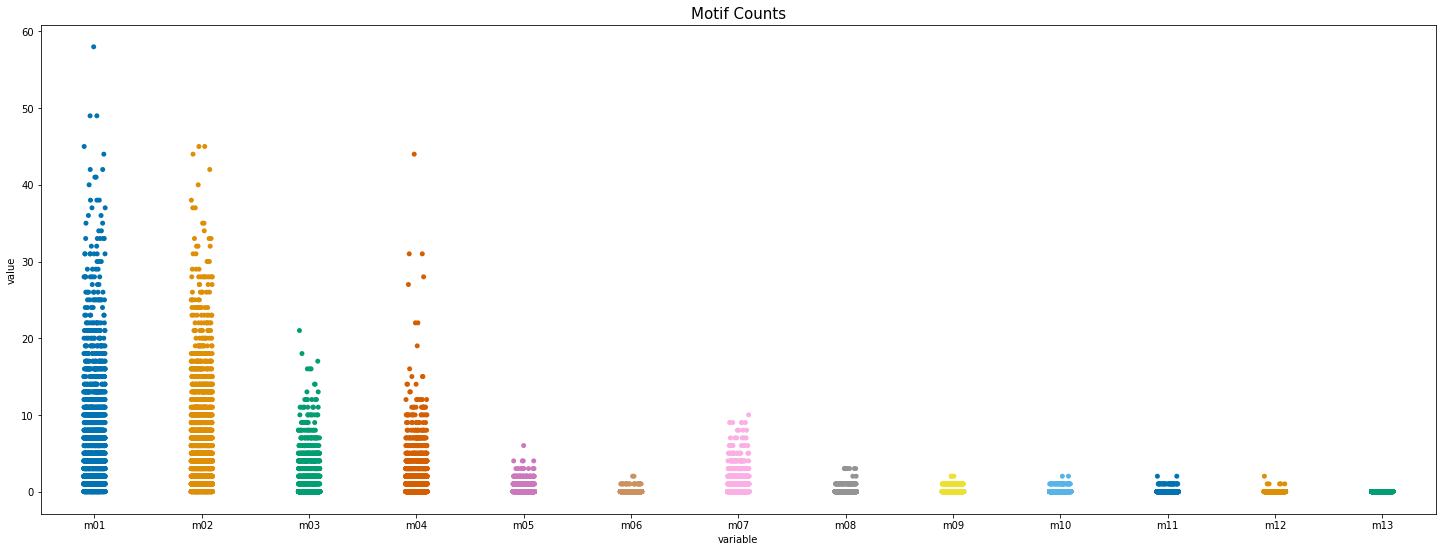

In [8]:
# ----------- Plot Motif Counts : Stripplot -----------
# Reformat df for strip plot
df_m = pd.melt(df, id_vars=df.columns[0], value_vars=motif_cols)
# strip plot
fig = plt.figure(figsize=(25, 9))
plt.title('Motif Counts', fontsize=15)
sns.stripplot(y='value', x='variable',
              data=df_m,
              palette="colorblind",
              )

output_dir = '/Users/CN/Dropbox/speech_graphs/all_tats/figures/'
output = op.join(output_dir, 'Scatter_motif_counts' +
                 '_{0}'.format(str(datetime.date.today())))
plt.savefig(output)
plt.show()

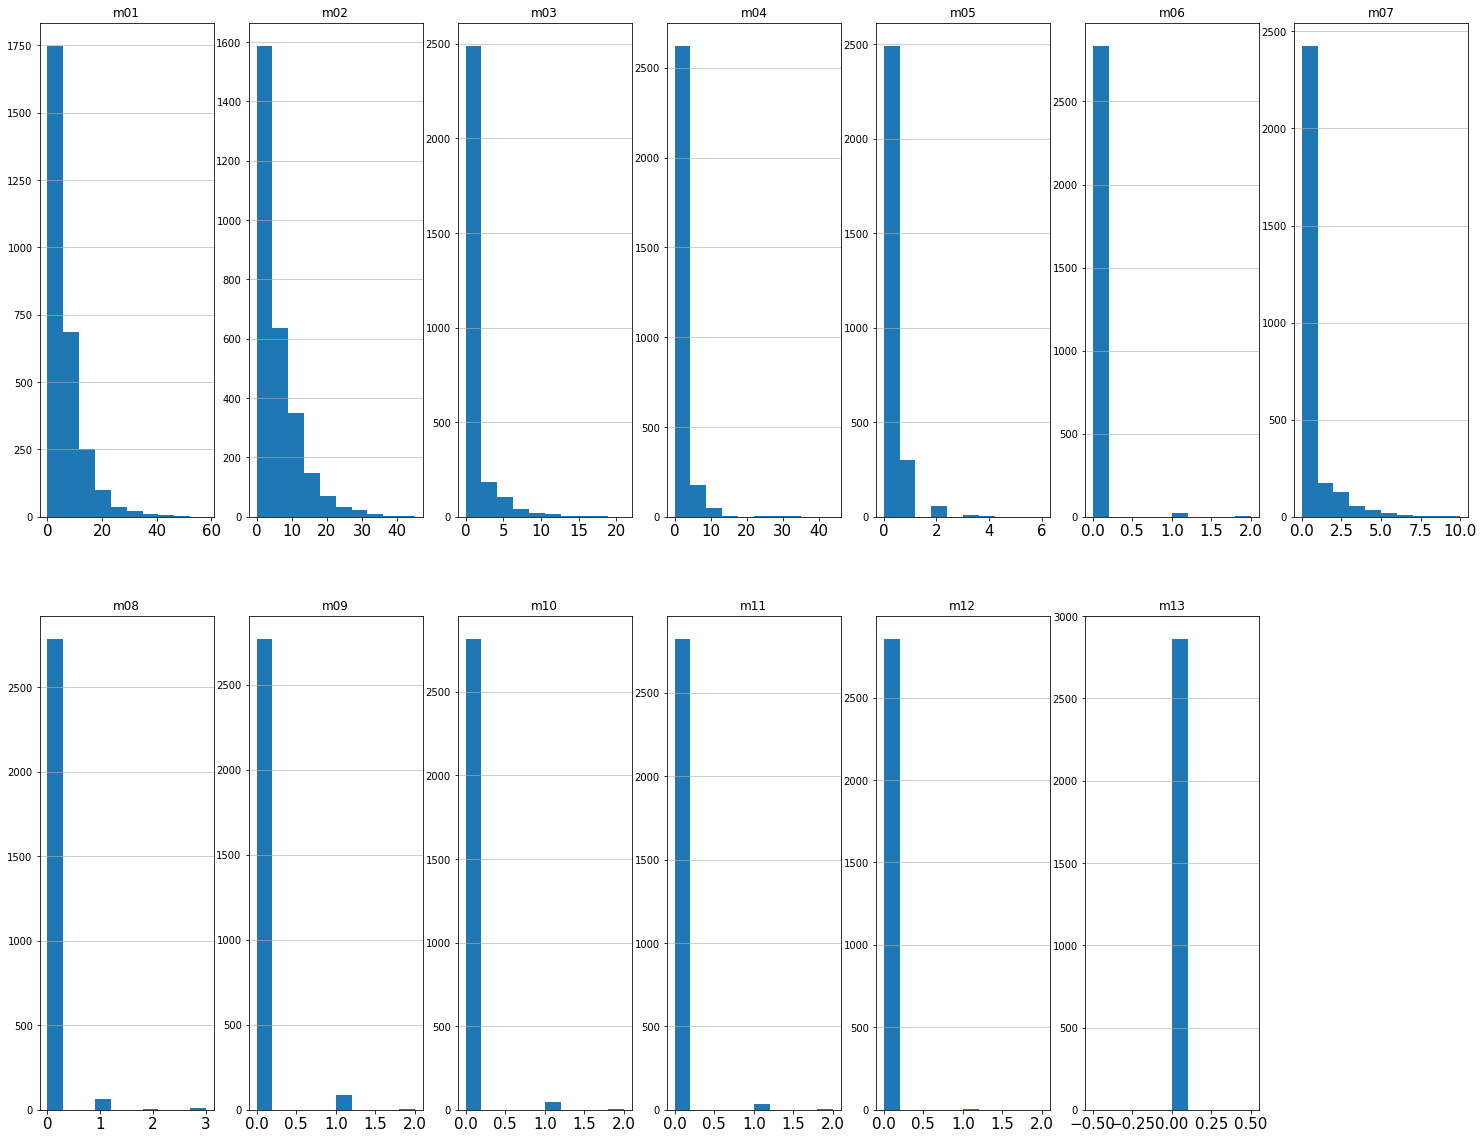

In [9]:
# ----------- Plot Motif Counts : Histogram -----------
fig = plt.figure(figsize=(25.6, 20))
no_motifs = len(motifs)
for m, mkey in enumerate(motifs):
    ax = plt.subplot(2, int(np.ceil(no_motifs / 2)), m + 1)
    plt.hist(df[mkey])  # , bins=100)
    plt.grid(axis='y', alpha=0.75)
    # plt.ylabel('Frequency', fontsize=15)
    plt.xticks(fontsize=15)
    plt.title(mkey)

output_dir = '/Users/CN/Dropbox/speech_graphs/all_tats/figures/'
output = op.join(output_dir, 'Hist_motif_counts' +
                 '_{0}'.format(str(datetime.date.today())))
plt.savefig(output)
plt.show()

ipykernel_launcher:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


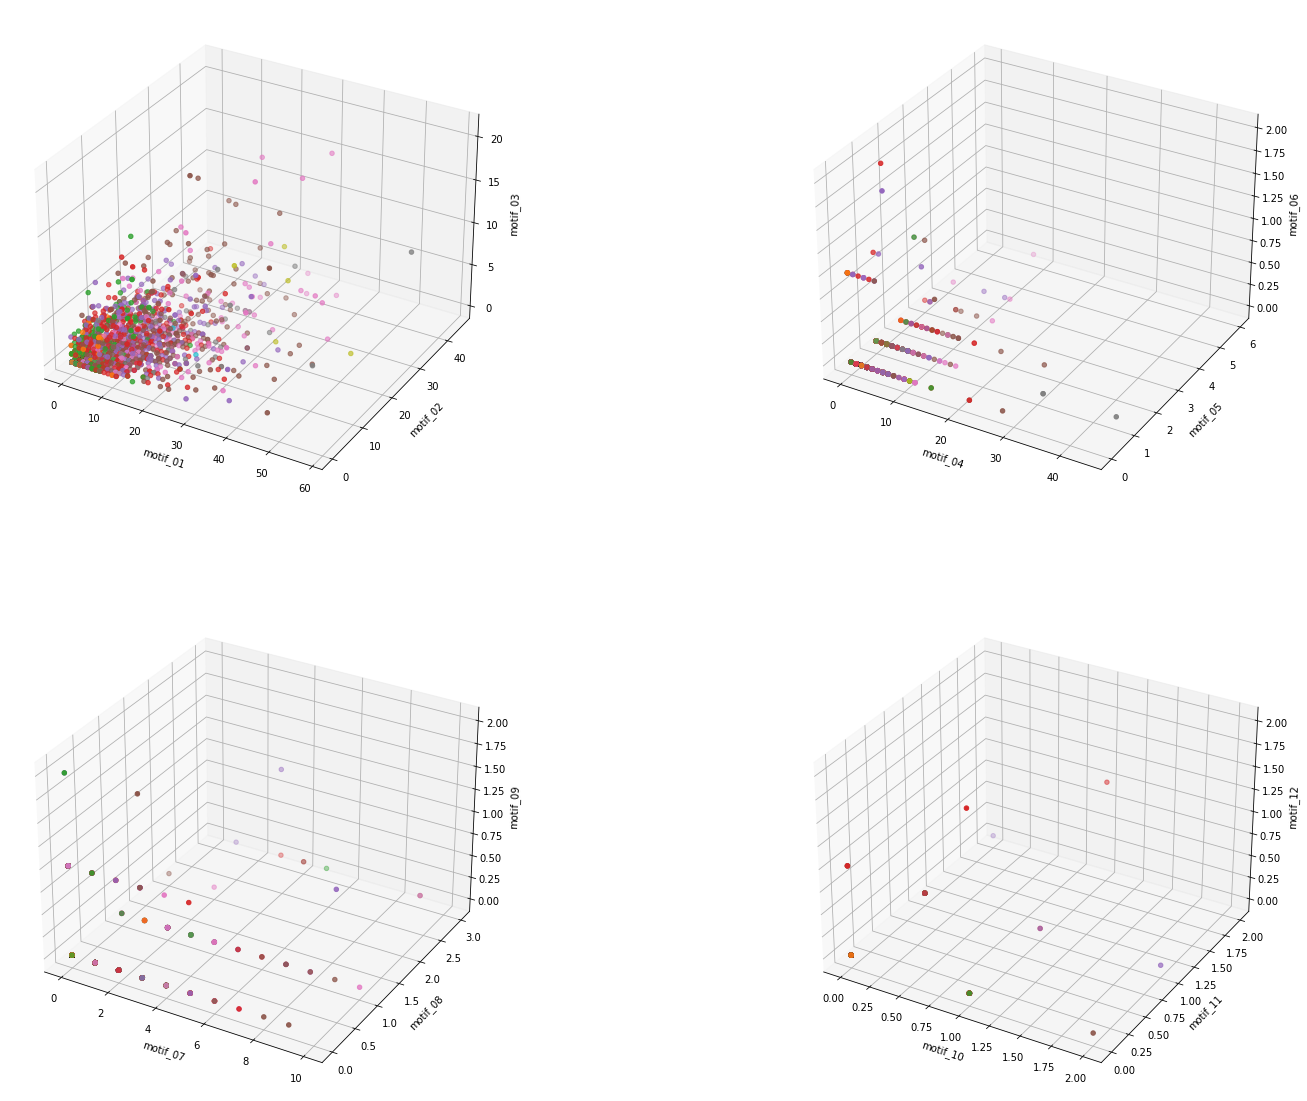

In [10]:
# ----------- Plot Motif Counts : 3D -----------
fig = plt.figure(figsize=(25.6, 20))
for m in range(0, 12, 3):
    ax = fig.add_subplot(2, 2, (m / 3) + 1, projection='3d')
    ax.scatter(
        xs=df[f'm{m+1:02d}'],
        ys=df[f'm{m+2:02d}'],
        zs=df[f'm{m+3:02d}'],
        c=pd.to_numeric(df.nodes),
        cmap='tab10',
    )
    ax.set_xlabel(f'motif_{m+1:02d}')
    ax.set_ylabel(f'motif_{m+2:02d}')
    ax.set_zlabel(f'motif_{m+3:02d}')

plt.show()
